# Análisis de la conformación con mejor AUC

In [1]:
import pandas as pd
import numpy as np

### Carga de los datos

In [2]:
# Carga de los datos por conformación
data_dir = './B_DATOS'
df_cdk2_labels = pd.read_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json")
# Sólo la necesitamos para saber cual es la mejor conformación según su AUC

In [3]:
# Seleccionamos las columnas que poseen los scores para cada método usado
df_auc_scores = df_cdk2_labels[['AUC_ad4_LE', 'AUC_ad4_LC', 
                'AUC_vina', 'AUC_vrd_8x', 'AUC_vrd_16x']]
df_auc_scores.shape

(402, 5)

### Elección de la conformación con mejor AUC

In [4]:
# Seleccionamos la conformación con mejor AUC en vinardo_16x
best_conf = df_auc_scores[['AUC_vrd_16x']].idxmax()[0]
best_conf
# conformación 2vv9

'2vv9'

### Carga de los scores por ligando por conformación

In [5]:
# Directorio de los scores por ligando
data_dir = './B_DATOS'
# Carga de los dataFrames
# Autodock 4. LE (lowest energy), LC (largest Cluster)
df_ad4_results_LE = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LE.csv', index_col=0)
df_ad4_results_LC = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LC.csv', index_col=0)
# Autodock Vina
df_vina_results = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINA.csv', index_col=0)
# Vinardo scoring
df_vinardo_results_16x = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINARDO.csv', index_col=0)
# Vinardo scoring exh 8
df_vinardo_results_ex8 = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINARDO_ex8.csv', index_col=0)

### DataFrame de la mejor conformación
#### Con sus respectivos valores de scoring por ligandos

In [6]:
# Creamos el DF para la conformación 2vv9
is_active = df_ad4_results_LE.ActiveInactive == "Active"
cols_names = {'Activity': is_active,
              'ad4_LE': df_ad4_results_LE[best_conf], 
              'ad4_LC': df_ad4_results_LC[best_conf], 
              'vina': df_vina_results[best_conf], 
              'vrd_8x': df_vinardo_results_16x[best_conf],
              'vrd_16x': df_vinardo_results_ex8[best_conf]}

df_conf_2vv9 = pd.DataFrame(cols_names)

df_conf_2vv9

,Activity,ad4_LE,ad4_LC,vina,vrd_8x,vrd_16x
Ligando,,,,,,
CS1,True,-7.94,-7.85,-7.7,-7.1,-7.1
CS2,True,-6.63,-6.36,-6.8,-7.8,-7.8
CS3,True,-8.98,-8.98,-8.5,-7.3,-7.3
CS4,True,-9.02,-9.02,-8.3,-8.1,-8.1
CS5,False,-10.23,-10.23,-8.6,-7.7,-7.7
...,...,...,...,...,...,...
CS247,True,-11.32,-10.94,-11.0,-11.0,-11.0
CS248,True,-11.23,-11.23,-9.5,-10.0,-10.0
CS260,True,-9.60,-9.60,-9.9,-9.3,-9.3


***
# Empieza el análisis
## Rankings de los ligandos de la mejor conformación

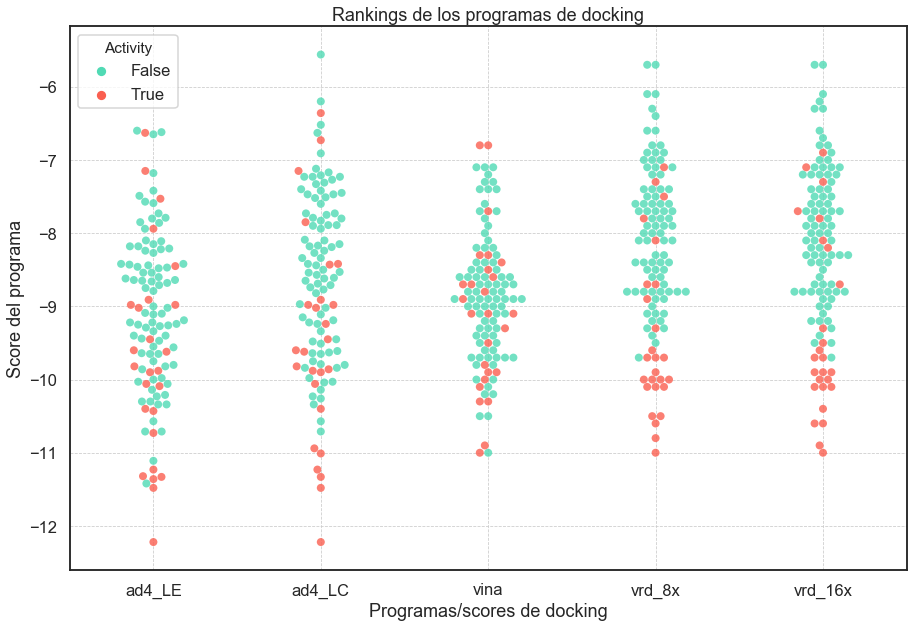

In [51]:
# Plot del ranking
import matplotlib.pyplot as  plt
import seaborn as sns
sns.set( context = 'talk', style = 'white')

data = df_conf_2vv9.drop(['Activity'], axis = 1).melt()
data['Activity'] = np.tile(is_active, 5)

cmp_ranking = sns.color_palette(["#50DAB4", "#FA5F50"])

fig, axes = plt.subplots()
fig.set_size_inches(15, 10)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Activity", s = 8, palette = cmp_ranking)
axes.set_title('Rankings de los programas de docking')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas/scores de docking")
plt.ylabel("Score del programa")
plt.show()

> ## Nota:  
Los ligandos en los rankings de Vina y Vinardo se ven más apilados porque sus scores (energía de interacción) sólo tienen un cifra decimal mientras que AD4 reporta sus valores con dos cifras decimales.

***
# Frente de pareto de los ligandos con la conf. 2vv9

In [151]:
# Funciones necesarias para calcular el frente de pareto

class Pareto:
    def __init__(self, df_scores, methods, minimize = True):
        self.methods = methods
        self.df_scores = df_scores
        self.counter = 0
        self.minimize = minimize
        self.fronts_dic = {}

    def pareto_front(self, scores):
        ''' Función para determinar si una observación pertenece 
        al frente no dominado dado un arreglo de n_observaciones, 
        y m_scores de las funciones objetivo.
        '''
        # Se crea un arreglo inicial de tamaño igual al número de observaciones
        # Todos los elementos se inicializan como parte del frente no dominado ( = 1)
        pareto_front = np.ones(scores.shape[0], dtype = bool)
        # Se itera sobre cada observación
        for i, s in enumerate(scores):
            # Comprueba si el punto i domina a los demás elementos
            if not np.all(np.any(scores[i] > scores[:i], axis=1)): # Para elementos 
                pareto_front[i] = 0
                continue
            if not np.all(np.any(scores[i] > scores[i+1:], axis=1)):
                pareto_front[i] = 0
        return pareto_front
    
    def get_front(self, df_scores):
        scores_sub_mtx = df_scores[self.methods].to_numpy()
        if self.minimize:
            scores_sub_mtx = scores_sub_mtx*-1
        pareto_points = self.pareto_front(scores_sub_mtx) # Se calculan lso scores
        df_pareto = df_scores[pareto_points]
        return(df_pareto)
    
    def get_pareto_front(self):
        df_pareto = self.get_front(self.df_scores)
        return(df_pareto)
    
    def get_all_fronts(self, df_scores = None, just_actives = True):
        if df_scores is None:
            df_scores = self.df_scores
        df_pf = self.get_front(df_scores)
        efficient_confs = df_pf.index.to_numpy()
        if len(efficient_confs) > 0:
            is_active = df_pf['Activity']
            self.counter = self.counter + 1
            self.fronts_dic[F'Frente_{self.counter}'] = efficient_confs
            if np.any(is_active) or not just_actives:
                df_scores = df_scores.drop(efficient_confs)
                self.get_all_fronts(df_scores, just_actives = just_actives)
        return(self.fronts_dic)
    
    def get_num_of_actives_per_front(self):
        print(F'Número total de frentes: {len(self.fronts_dic)}')
        print("___________________________________")
        for frente, puntos in self.fronts_dic.items():
            puntos_df = self.df_scores.loc[puntos][['Activity']]
            n_elementos = ( puntos_df.count())[0]
            n_activos = puntos_df.sum()[0]
            print(F'{frente}: {n_activos}/{n_elementos} activos.')
            print(puntos_df.T)
            print("___________________________________")


    def get_pareto_front_2(self):
        scores_np = scores[metodos].to_numpy() # Se convierte el DataFrame a matriz de numpy
        pareto_points = pareto_front(scores_np, minimize=minimize) # Se calculan lso scores
        df_pareto = scores[pareto_points]
        # Graficamos
        #if plot:
         #   plt.figure(figsize=(6, 6))
          #  sns.lineplot(df_pareto[metodos[0]], df_pareto[metodos[1]])
           # sns.scatterplot(scores[metodos[0]], scores[metodos[1]], 
            #                hue=pareto_points, s=75, palette= cmp)
        return(df_pareto[['Activity'] + metodos])


    

In [152]:
metodos = ['ad4_LE', 'ad4_LC', 'vina', 'vrd_8x', 'vrd_16x']
a = Pareto(df_conf_2vv9, metodos, minimize = True)
x = a.get_all_fronts(just_actives = False)
a.get_num_of_actives_per_front()

Número total de frentes: 13
___________________________________
Frente_1: 4/4 activos.
Ligando   CS244  CS245  CS247  CS261
Activity   True   True   True   True
___________________________________
Frente_2: 4/8 activos.
Ligando    CS74  CS110  CS232  CS238  CS241  CS242  CS246  CS262
Activity  False  False  False  False   True   True   True   True
___________________________________
Frente_3: 4/12 activos.
Ligando   CS17  CS20   CS34   CS36   CS70   CS71  CS102  CS112  CS148  CS166  \
Activity  True  True  False  False  False  False  False  False  False  False   

Ligando   CS248  CS260  
Activity   True   True  
___________________________________
Frente_4: 3/12 activos.
Ligando   CS16  CS18  CS19   CS67   CS68   CS81   CS82  CS100  CS140  CS165  \
Activity  True  True  True  False  False  False  False  False  False  False   

Ligando   CS188  CS196  
Activity  False  False  
___________________________________
Frente_5: 3/9 activos.
Ligando     CS5  CS10  CS13  CS15   CS31   CS38   C

In [71]:
df_conf_2vv9.loc[['CS247', 'CS261', 'CS244', 'CS246', 'CS17', 'CS260']]

,Activity,ad4_LE,ad4_LC,vina,vrd_8x,vrd_16x
Ligando,,,,,,
CS247,True,-11.32,-10.94,-11.0,-11.0,-11.0
CS261,True,-11.36,-11.01,-9.8,-10.8,-10.9
CS244,True,-12.22,-12.22,-10.1,-10.6,-10.6
CS246,True,-11.33,-11.33,-9.9,-10.5,-10.6
CS17,True,-10.43,-9.24,-8.8,-10.5,-10.4
CS260,True,-9.60,-9.60,-9.9,-9.3,-9.3


In [54]:
a = Pareto(df_conf_2vv9.drop(['CS247', 'CS261', 'CS244', 'CS246', 'CS17', 'CS260']), metodos, minimize = True)
a.get_pareto_front()

,Activity,ad4_LE,ad4_LC,vina,vrd_8x,vrd_16x
Ligando,,,,,,


## Ejemplos por pares de scorings
Como ejemplo de los frentes generados vamos a visualizar por pares de scorings antes de generar frentes con más de un método de docking/scoring.

In [ ]:
# Vina vs ad4_LC
metodos = ['vina', 'ad4_LC']
get_pareto_front(df_conf_2vv9, metodos, minimize=True)

In [ ]:
# Vina vs vinardo_16x
metodos = ['vina', 'vrd_16x']
get_pareto_front(df_conf_2vv9, metodos, minimize=True)

In [ ]:
# Vina vs vinardo_16x
metodos = ['vina', 'vrd_8x']
get_pareto_front(df_conf_2vv9, metodos, minimize=True)

In [ ]:
# Vina vs vinardo_16x
metodos = ['vrd_8x', 'ad4_LC']
get_pareto_front(df_conf_2vv9, metodos, minimize=True)

# Frente combinando más de dos scores

## Los 5 scores (5 objetivos)

In [ ]:
metodos = ['ad4_LE', 'ad4_LC', 'vina', 'vrd_8x', 'vrd_16x']
get_pareto_front(df_conf_2vv9, metodos, minimize=True, plot = False)

In [ ]:
get_pareto_front(df_conf_2vv9.drop(['CS244', 'CS245', 'CS247', 'CS261']), metodos, minimize=True, plot = False)

## Sin ad4_LE 

In [ ]:
metodos = ['ad4_LC', 'vina', 'vrd_8x', 'vrd_16x']
get_pareto_front(df_conf_2vv9, metodos, minimize=True, plot = False)

## Sin ad4_LC

In [ ]:
metodos = ['ad4_LE', 'vina', 'vrd_8x', 'vrd_16x']
get_pareto_front(df_conf_2vv9, metodos, minimize=True, plot = False)

## Sin Vina

In [ ]:
metodos = ['ad4_LE', 'ad4_LC', 'vrd_8x', 'vrd_16x']
get_pareto_front(df_conf_2vv9, metodos, minimize=True, plot = False)

## Sin vinardo_8x

In [ ]:
metodos = ['ad4_LE', 'ad4_LC', 'vina',  'vrd_16x']
get_pareto_front(df_conf_2vv9, metodos, minimize=True, plot = False)

## Sin vinardo_16x

In [ ]:
metodos = ['ad4_LE', 'ad4_LC', 'vina', 'vrd_8x']
get_pareto_front(df_conf_2vv9, metodos, minimize=True, plot = False)

## Sin vinardos

In [ ]:
metodos = ['ad4_LE', 'ad4_LC', 'vina']
get_pareto_front(df_conf_2vv9, metodos, minimize=True, plot = False)

## Sin ad4s

In [ ]:
metodos = ['vina', 'vrd_8x', 'vrd_16x']
get_pareto_front(df_conf_2vv9, metodos, minimize=True, plot = False)